In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# root = Path("/mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only/")
# root = Path("/mnt/ssd-1/alexm/w2s/results/sciq_support_contains/")
root = Path("/mnt/ssd-1/alexm/w2s/results/ethics_deontology_excuse_only/")

In [20]:
# all subdirectories of the form `run_name`*
# title = "Amazon Polarity \"look at title only\" multiple oracle epochs"
# title = "Sciq with support \"does context contain `ans`\""
suffix = "_sft2"
data = []
configs = []
subdirs = [
    f"am_title_0{suffix}",
    f"am_title_32x48{suffix}",
    # f"am_title_128x12{suffix}",
    f"am_title_512{suffix}",
    f"am_title_512x4{suffix}",
    # f"am_title_2000{suffix}",
    # f"am_title_2000x4{suffix}",
    f"am_title_8000{suffix}",
    # "am_title_0_orepoch",
    # "am_title_32x48_orepoch",
    # "am_title_128x12_orepoch",
    # "am_title_512_orepoch",
    # "am_title_512x4_orepoch",
    # "am_title_2000_orepoch",
    # "am_title_2000x4_orepoch",
    # "am_title_8000_orepoch",
    # "am_title_0_matching",
    # "am_title_32x48_matching",
    # "am_title_128x12_matching",
    # "am_title_512_matching",
    # "am_title_512x4_matching",
    # "am_title_2000_matching",
    # "am_title_2000x4_matching",
    # "am_title_8000_matching",
    # "ss_contains_0",
    # "ss_contains_32x48",
    # "ss_contains_128x12",
    # "ss_contains_512",
    # "ss_contains_512x4",
    # "ss_contains_2000",
    # "ss_contains_2000x4",
    # "ss_contains_8000",
    # 'am_title_0',
    # 'am_title_32x48',
    # 'am_title_128x12',
    # 'am_title_512',
    # 'am_title_512x4',
    # 'am_title_2000',
    # 'am_title_2000x4',
    # 'am_title_8000',
]

names = []
for name in subdirs:
    d = root / name
    # df = pd.read_json(d / "results.json", orient="records", lines=True)
    dicts = []
    for fname in d.glob("results_*.json"):
        with open(fname) as f:
            dicts.append(json.load(f))
    if len(dicts) == 0:
        continue
    df = pd.DataFrame(dicts).sort_values("num_oracle")
    # with open(d / "config.json") as f:
    #     config = json.load(f)
    data.append(df)
    names.append(name)
    # configs.append(config)


In [25]:
data[1]

,auroc,acc,auroc_against_weak,acc_against_weak,weak_soft_labels,num_weak,num_oracle,oracle_ids,ids,calibrated_logodds,gt_soft_labels
1,0.925848,0.854000,0.893307,0.819000,"[0.7732163667678833, 0.3081902265548706, 0.234...",32,0,[],"[31103764, 92dbe902, 94f2476d, b8888357, 64873...","[0.609375, -0.04357147216796875, -0.2607421875...","[1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ..."
6,0.931205,0.708667,0.885839,0.713000,"[0.7732163667678833, 0.3081902265548706, 0.234...",32,4,"[165fb7c0, d261facc, 59d70839, 9089959b]","[31103764, 92dbe902, 94f2476d, b8888357, 64873...","[-4.734375, -5.515625, -7.4375, -6.828125, 6.1...","[1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ..."
5,0.925290,0.810667,0.883546,0.789667,"[0.7732163667678833, 0.3081902265548706, 0.234...",32,16,"[0b2875b2, 13878dfb, 395e8287, 40e0a328, 53fb3...","[31103764, 92dbe902, 94f2476d, b8888357, 64873...","[0.7578125, 7.234375, -7.921875, -7.390625, 8....","[1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ..."
4,0.981245,0.947333,0.921749,0.875000,"[0.7732163667678833, 0.3081902265548706, 0.234...",32,64,"[30a900d5, 0b2875b2, 69d1ca0f, 917f9b38, 1242a...","[31103764, 92dbe902, 94f2476d, b8888357, 64873...","[9.25, 9.21875, -10.34375, -10.375, 8.71875, -...","[1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ..."
0,0.990007,0.966667,0.899895,0.861667,"[0.7732163667678833, 0.3081902265548706, 0.234...",32,256,"[850fc54f, e7df8319, 7f329aa8, 84b3b1ac, e660b...","[31103764, 92dbe902, 94f2476d, b8888357, 64873...","[6.6875, 5.984375, -7.34375, -6.578125, 5.9843...","[1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ..."
3,0.992837,0.970333,0.929898,0.858000,"[0.7732163667678833, 0.3081902265548706, 0.234...",32,1024,"[850fc54f, 0e515d36, 240c98b0, 97928a76, bc7ea...","[31103764, 92dbe902, 94f2476d, b8888357, 64873...","[6.40625, 5.5625, -6.671875, -6.046875, 6.2187...","[1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ..."
2,0.994496,0.974000,0.923934,0.855000,"[0.7732163667678833, 0.3081902265548706, 0.234...",32,4096,"[850fc54f, 3e677108, d53443eb, 97928a76, e5a51...","[31103764, 92dbe902, 94f2476d, b8888357, 64873...","[6.40625, 5.328125, -7.03125, -5.765625, 5.578...","[1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ..."


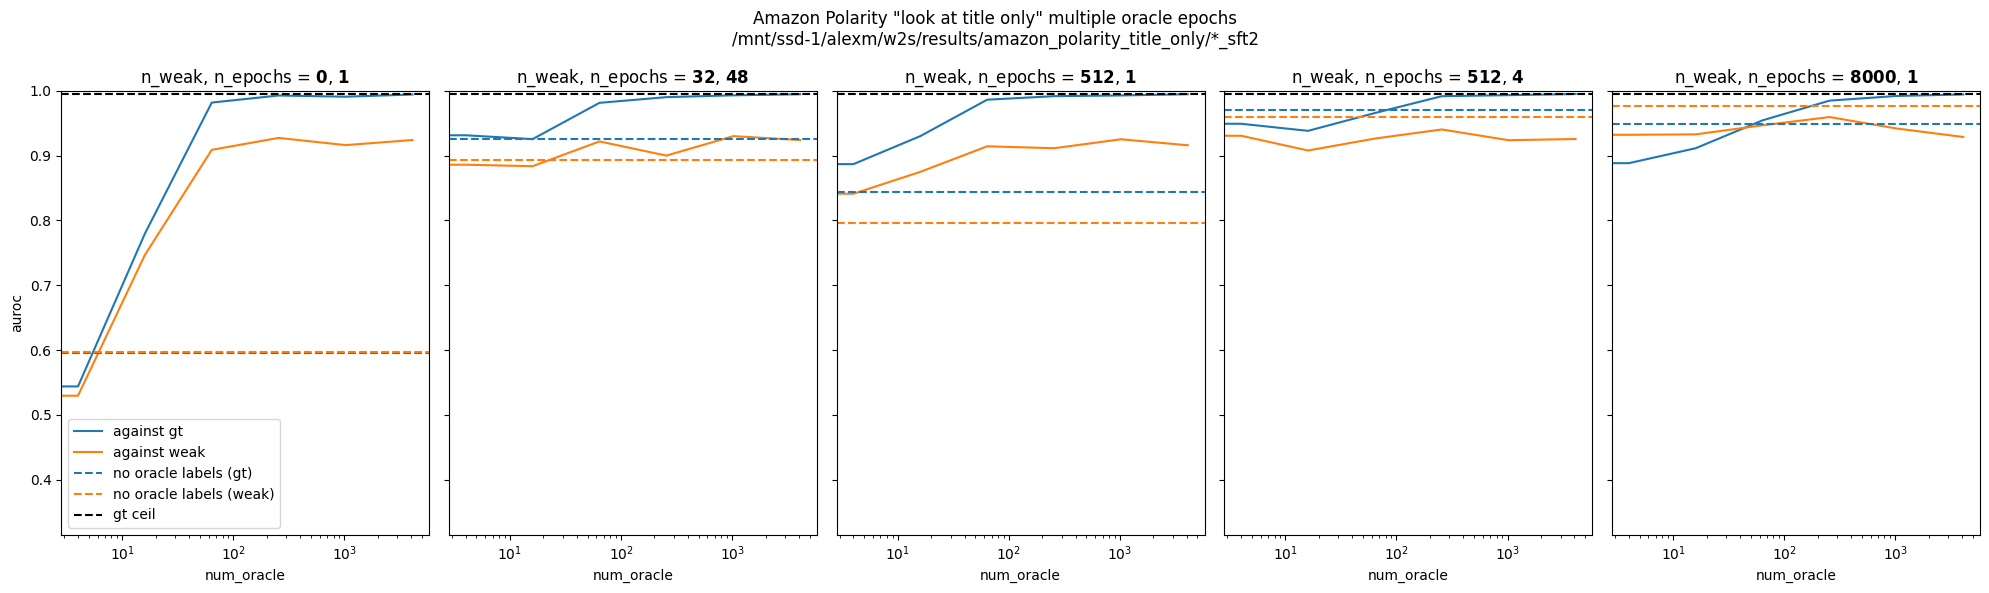

In [24]:
# I want a horizontal grid of aligned subplots, one for each n_weak, with x-axis=n_oracle, and y_axis=auroc

rows, cols = 1, 5
fig, axs = plt.subplots(rows, cols, figsize=(20, 6), sharey=True, sharex=True)
metric = "auroc"
for i, (df, name) in enumerate(zip(data, names)):
    if i == 0:
        gt_ceil = df[metric].max()
    ax = axs[i // cols, i % cols] if rows > 1 else axs[i % cols]
    plt.sca(ax)
    plt.ylim(0.315, 1)
    sns.lineplot(x="num_oracle", y=metric, data=df, label="against gt" if i == 0 else None)
    sns.lineplot(x="num_oracle", y=f"{metric}_against_weak", data=df, label="against weak" if i == 0 else None)
    # horizontal lines for num_oracle = 0
    zero_row = df[df["num_oracle"] == 0]
    ax.axhline(zero_row[metric].values[0], color="tab:blue", linestyle="--", label="no oracle labels (gt)" if i == 0 else None)
    ax.axhline(zero_row[f"{metric}_against_weak"].values[0], color="tab:orange", linestyle="--", label="no oracle labels (weak)" if i == 0 else None)
    ax.axhline(gt_ceil, color="black", linestyle="--", label="gt ceil" if i == 0 else None)
    if i == 0:
        plt.legend()

    last = name.split("_")[-2]
    if "x" in last:
        n_weak, n_epochs =last.split("x")
    else:
        n_weak = last
        n_epochs = "1"

    plt.title("n_weak, n_epochs = $\mathbf{" + n_weak + "}$, $\mathbf{" + n_epochs + "}$")
    plt.semilogx()
    plt.xlabel("num_oracle")
    plt.ylabel(metric)

plt.suptitle(f"{title}\n{root}/*{suffix}")
plt.tight_layout()
plt.show()

# multiple seeds

In [4]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

root = Path("/mnt/ssd-1/alexm/w2s/results/ethics_deontology_excuse_only/")
title = "Ethics Deontology excuse only"
prefix = "70B_ethics_excuse"
# root = Path("/mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only/")
# title = "Amazon Polarity \"look at title only\""
# prefix = "am_title"
# root = Path("/mnt/ssd-1/alexm/w2s/results/sciq_support_contains/")
# title = "Sciq with support \"does context contain `ans`\""
# prefix = "ss_contains"
min_num_oracle = 1

metric = "auroc"
sft_n_weak, sft_n_epochs = "1", "0"
sft_subdirs = root.glob(f"{prefix}_{sft_n_weak}x{sft_n_epochs}_seed*_sft")
active_n_weak, active_n_epochs = "32", "48"
active_subdirs = root.glob(f"{prefix}_{active_n_weak}x{active_n_epochs}_seed*_active")

# x-axis: num_oracle, y-axis: auroc
# one line for sft, one line for active, each with shaded error bars

sft_data = []
active_data = []
for name in sft_subdirs:
    d = name
    for fname in d.glob("results_*.json"):
        with open(fname) as f:
            sft_data.append(json.load(f))
for name in active_subdirs:
    d = name
    for fname in d.glob("results_*.json"):
        with open(fname) as f:
            active_data.append(json.load(f))

sft_df = pd.DataFrame(sft_data).sort_values("num_oracle")
active_df = pd.DataFrame(active_data).sort_values("num_oracle")
sft_df = sft_df[sft_df["num_oracle"] >= min_num_oracle]
active_df = active_df[active_df["num_oracle"] >= min_num_oracle]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.sca(ax)
plt.ylim(0.5, 1)
# plt.axhline(0.994, color="black", linestyle="--", label="gt ceil")  # NOTE: this is a placeholder
sns.lineplot(x="num_oracle", y=metric, data=sft_df, errorbar="sd", label=f"sft {sft_n_weak}x{sft_n_epochs} weak ($\pm$ sd)")
sns.lineplot(x="num_oracle", y=metric, data=active_df, errorbar="sd", label=f"active {active_n_weak}x{active_n_epochs} weak ($\pm$ sd)")
plt.semilogx(base=2)
plt.xlabel("num_oracle")
plt.ylabel(metric)
plt.legend()
plt.title(title)
plt.tight_layout()
plt.show()

KeyError: 'num_oracle'

In [44]:
import pandas as pd
import json
from pathlib import Path
from collections import defaultdict

root = Path("/mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only/")
globs = ["am_title_online_sampling_s1_*", "am_title_temp0.25_s3_*", "am_title_temp0.7_s3_*", "am_title_debug_*", "am_title_newseed_*", "am_title_newseed2_*", "am_title_online_sampling_s2_*", "am_title_online_sampling_s2_*1"] #"am_title_one_epoch_*"]

def remove_large_entries(r):
    r = r.copy()
    for k in {"weak_soft_labels", "ids", "oracle_ids", "calibrated_logodds", "gt_soft_labels"}:
        if k in r:
            del r[k]
    return r


datas = []
for glob in globs:
    subdirs = root.glob(glob)
    
    for subdir in subdirs:
        try:
            data = remove_large_entries(json.load((subdir / "results.json").open()))
            cfg = json.load((subdir / "config.json").open())
            data.update(cfg)
            data["cfg"] = cfg
            data.update({"method": subdir.name})
            print(subdir)
        except FileNotFoundError:
            print(f"missing {subdir}")
            continue
        
        datas.append(data)
df = pd.DataFrame(datas)

missing /mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only/am_title_online_sampling_s1_0
missing /mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only/am_title_online_sampling_s1_2
missing /mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only/am_title_online_sampling_s1_1
/mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only/am_title_temp0.25_s3_4
/mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only/am_title_temp0.25_s3_1
/mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only/am_title_temp0.25_s3_0
/mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only/am_title_temp0.25_s3_2
/mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only/am_title_temp0.25_s3_3
/mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only/am_title_temp0.7_s3_4
/mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only/am_title_temp0.7_s3_1
/mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only/am_title_temp0.7_s3_3
/mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only/am_title_temp0.7_s3_2
/mnt/ssd-1/

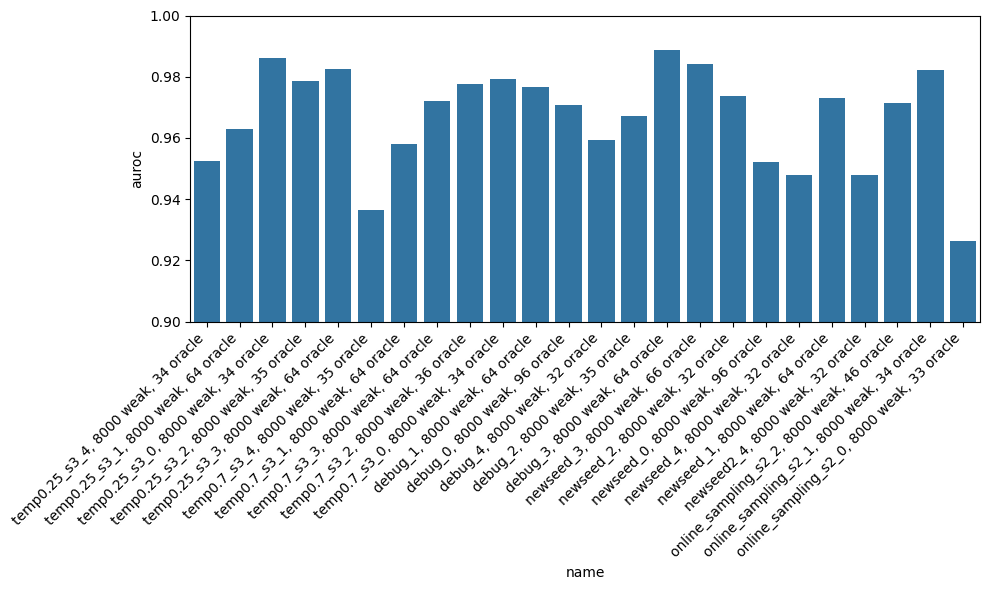

In [47]:
# I want a plot of AUROC vs method (with num_oracle, num_weak) in the method name
import seaborn as sns
import matplotlib.pyplot as plt

df["name"] = df.apply(lambda r: r['method'].replace("am_title_", "") + f", {r['num_weak']} weak, {r['num_oracle']} oracle", axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.sca(ax)
plt.ylim(0.9, 1)
sns.barplot(x="name", y="auroc", data=df)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()


In [39]:
sorted_df = df.sort_values("auroc", ascending=False)
for i, row in sorted_df.iloc[:5].iterrows():
    print(row["name"], row["auroc"])
    # cfg_str = json.dumps(row["cfg"], indent=2)
    # print(cfg_str, "\n\n\n\n\n\n")

debug_3, 8000 weak, 64 oracle 0.988709568977356
temp0.25_s3_0, 8000 weak, 34 oracle 0.9862375855445862
newseed_3, 8000 weak, 66 oracle 0.9842044711112976
temp0.25_s3_3, 8000 weak, 64 oracle 0.9825111031532288
temp0.7_s3_0, 8000 weak, 34 oracle 0.9792786240577698


In [8]:
[(setting, d["num_oracle"], d["auroc"]) for setting, dat in datas.items() for d in dat]

[(4, 34, 0.9525691270828247),
 (4, 35, 0.9364919066429138),
 (1, 64, 0.9628642797470093),
 (1, 64, 0.9579855799674988),
 (0, 34, 0.9862375855445862),
 (0, 34, 0.9792786240577698),
 (2, 35, 0.9784435629844666),
 (2, 36, 0.9777633547782898),
 (3, 64, 0.9825111031532288),
 (3, 64, 0.9719114303588867)]

# Salience

In [1]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("eleutherai/huggingface")
runs_by_name = {run.name: run for run in runs}

In [11]:
import numpy as np
from scipy import integrate

def compute_auc(run):
    
    # Extract the eval/test_loss history
    history = run.scan_history(keys=["eval/test_loss", "train/global_step", "eval/test_auroc"])
    losses = [row["eval/test_loss"] for row in history]
    steps = [row["train/global_step"] for row in history]
    aurocs = [row["eval/test_auroc"] for row in history]
    try:
        batch_size = run.config.get("per_device_train_batch_size") * run.config.get("gradient_accumulation_steps")
    except TypeError:
        print(f"Run '{run.name}' does not have the necessary config values for AUC calculation.")
        return
    
    if isinstance(losses, list) and len(losses) > 1:
        aurocs = np.array(aurocs)
        near_max_idxs = np.nonzero(aurocs > 0.5 + 0.95 * (aurocs.max() - 0.5))
        first_good_idx = near_max_idxs[0][0] if len(near_max_idxs[0]) > 0 else len(losses) - 1
        smallest_good_num_points = steps[first_good_idx] * batch_size
        
        # Assuming the x-axis is the step or epoch number
        x = np.array(steps)
        losses = np.array(losses)

        try:
            integrate_to = (x == 60).nonzero()[0][0]
        except IndexError:
            print(f"Run '{run.name}' does not have enough data points for AUC calculation.")
            return
        
        x = x[:integrate_to]
        losses = losses[:integrate_to]
        aurocs = aurocs[:integrate_to]
        
        # Compute the area under the curve
        auc = integrate.simpson(losses, x=x)
        salience = integrate.simpson(aurocs, x=x)
        
        auc_result = {
            'name': run.name,
            'loss_auc': auc,
            'salience': salience,
            'steps': steps,
            'losses': losses,
            'aurocs': aurocs,
            'seed': run.config.get("seed"),
            'smallest_good_num_points': smallest_good_num_points
        }
    else:
        print(f"Run '{run.name}' does not have enough data points for AUC calculation.")
        return
    
    return auc_result

In [12]:
# from datasets import load_from_disk
# from sklearn.metrics import roc_auc_score, accuracy_score

# ds_names = ["boolq_Qwen1.5-0.5B"]
# ds_names += [f"{ds_name}_{prompt}" for ds_name in ["paws_consistency", "ethics_deontology_excuse_only", "amazon_polarity_title_only", "sciq_support_contains"] for prompt in ["weak_amplified", "both_amplified", "neither_amplified", "gt_amplified"]]

# auc_results = []
# for ds_name in ds_names:
#     for target in ["weak", "oracle"]:
#         run_name = f"{ds_name}_salience_{target}_s42"
#         run = runs_by_name.get(run_name)
#         if run and (result := compute_auc(run)):
#             train_ds = load_from_disk(f"results/{ds_name}/weak_train")
#             soft_pred, soft_label = np.array(train_ds["soft_pred"])[:, 1], np.array(train_ds["soft_label"])[:, 1]
#             auroc, acc = roc_auc_score(soft_label, soft_pred), accuracy_score(soft_label > 0.5, soft_pred > 0.5)
#             result.update({
#                 "ds_name": ds_name,
#                 "model_name": run.config["_name_or_path"],
#                 "against": target,
#                 "weak_label_auroc": auroc,
#                 "weak_label_acc": acc
#             })
#             auc_results.append(result)
# auc_df = pd.DataFrame(auc_results)

In [14]:
from datasets import load_from_disk
from sklearn.metrics import roc_auc_score, accuracy_score
import re

auc_results = []
for run in runs:
    # run_name = f"{ds_name}_salience_{target}_s42"
    if "_salience_" in run.name and run.name[-1].isdigit() and ("_weak_" in run.name or "_oracle_" in run.name) and run.metadata["codePath"] and run.metadata["codePath"] == "salience.py":
        if run and (result := compute_auc(run)):
            target = run.name.split("_")[-2]
            ds_name = "_".join(run.name.split("_")[:-3])
            train_ds = load_from_disk(f"results/{ds_name}/weak_train")
            soft_pred, soft_label = np.array(train_ds["soft_pred"])[:, 1], np.array(train_ds["soft_label"])[:, 1]
            auroc, acc = roc_auc_score(soft_label, soft_pred), accuracy_score(soft_label > 0.5, soft_pred > 0.5)
            result.update({
                "ds_name": ds_name,
                "model_name": run.config["_name_or_path"],
                "against": target,
                "weak_label_auroc": auroc,
                "weak_label_acc": acc
            })
            auc_results.append(result)
auc_df = pd.DataFrame(auc_results)

Run 'amazon_polarity_title_only_weak_amplified_salience_oracle_s0' does not have enough data points for AUC calculation.
Run 'amazon_polarity_title_only_gt_amplified_salience_weak_s42' does not have the necessary config values for AUC calculation.
Run 'sciq_support_contains_weak_amplified_salience_oracle_s42' does not have enough data points for AUC calculation.
Run 'sciq_support_contains_weak_amplified_salience_weak_s42' does not have enough data points for AUC calculation.
Run 'sciq_support_contains_both_amplified_salience_oracle_s42' does not have enough data points for AUC calculation.
Run 'sciq_support_contains_both_amplified_salience_weak_s42' does not have enough data points for AUC calculation.
Run 'sciq_support_contains_neither_amplified_salience_oracle_s42' does not have enough data points for AUC calculation.
Run 'sciq_support_contains_neither_amplified_salience_weak_s42' does not have enough data points for AUC calculation.
Run 'sciq_support_contains_gt_amplified_salience_o

In [15]:
auc_df[auc_df["against"] == "oracle"].sort_values("salience", ascending=False)

,name,loss_auc,salience,steps,losses,aurocs,seed,smallest_good_num_points,ds_name,model_name,against,weak_label_auroc,weak_label_acc
364,amazon_polarity_title_only_gt_amplified_salien...,8.288965,39.828694,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[0.6238152384757996, 0.26548171043395996, 0.08...","[0.9916574358940125, 0.9940013885498047, 0.997...",42,320,amazon_polarity_title_only_gt_amplified,Qwen/Qwen1.5-7B,oracle,0.923527,0.828076
293,amazon_polarity_title_only_weak_amplified_sali...,6.903101,39.825837,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[0.5976009964942932, 0.20984715223312378, 0.11...","[0.9914809465408325, 0.9945811033248901, 0.996...",42,320,amazon_polarity_title_only_weak_amplified,Qwen/Qwen1.5-7B,oracle,0.920233,0.832876
297,amazon_polarity_title_only_weak_amplified_sali...,7.311729,39.825710,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[0.598464846611023, 0.20869670808315277, 0.081...","[0.9904228448867798, 0.9958740472793579, 0.996...",42,320,amazon_polarity_title_only_weak_amplified,Qwen/Qwen1.5-7B,oracle,0.920233,0.832876
358,amazon_polarity_title_only_gt_amplified_salien...,7.230168,39.713849,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[0.5873532295227051, 0.20833314955234528, 0.11...","[0.9897671341896057, 0.9912793636322021, 0.994...",42,320,amazon_polarity_title_only_gt_amplified,Qwen/Qwen1.5-4B,oracle,0.923527,0.828076
287,amazon_polarity_title_only_weak_amplified_sali...,6.853982,39.701080,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[0.5827997326850891, 0.12772850692272186, 0.19...","[0.9845750331878662, 0.9925647974014282, 0.991...",42,320,amazon_polarity_title_only_weak_amplified,Qwen/Qwen1.5-4B,oracle,0.920233,0.832876
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,ethics_deontology_excuse_only_weak_amplified_s...,30.503669,21.583205,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[0.7003280520439148, 0.8151739239692688, 0.748...","[0.5165460109710693, 0.5002880096435547, 0.536...",42,4160,ethics_deontology_excuse_only_weak_amplified,Qwen/Qwen1.5-0.5B,oracle,0.841979,0.754120
188,ethics_deontology_excuse_only_weak_amplified_s...,30.319615,21.189445,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[0.6946075558662415, 0.7067474126815796, 0.716...","[0.5219630599021912, 0.49371230602264404, 0.52...",42,4800,ethics_deontology_excuse_only_weak_amplified,Qwen/Qwen1.5-0.5B,oracle,0.841979,0.754120
118,paws_consistency_both_amplified_salience_oracl...,29.244040,20.967772,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[0.6979385614395142, 0.720294177532196, 0.6903...","[0.4794996976852417, 0.5248780846595764, 0.535...",42,3840,paws_consistency_both_amplified,Qwen/Qwen1.5-0.5B,oracle,0.822583,0.747721
168,paws_consistency_gt_amplified_salience_oracle_s2,29.020095,20.724394,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[0.7150594592094421, 0.6991896629333496, 0.862...","[0.44375941157341003, 0.47684207558631897, 0.4...",42,3200,paws_consistency_gt_amplified,Qwen/Qwen1.5-0.5B,oracle,0.822583,0.747721


In [14]:
#group by ds_name and model_name
grouped_df = auc_df[auc_df["against"] == "oracle"].drop(["steps", "losses", "aurocs"], axis=1).groupby(["ds_name"]).std(numeric_only=True)

In [19]:
ds_name = "ethics_deontology_excuse_only_weak_amplified"
model_name = "Qwen/Qwen1.5-4B"
curr_df = auc_df[(auc_df["against"] == "oracle") & (auc_df["ds_name"] == ds_name) & (auc_df["model_name"] == model_name)]
curr_df

'ethics_deontology_excuse_only_weak_amplified_salience_oracle_s0'

In [16]:
auc_df.to_json("results/salience_results_all_models.json", orient="records", lines=True)

# Cost sweep

In [1]:
import pandas as pd

ds_names = ["boolq_Qwen1.5-0.5B"]
ds_names += [f"{ds_name}_{prompt}" for ds_name in ["paws_consistency", "ethics_deontology_excuse_only", "amazon_polarity_title_only", "sciq_support_contains"] for prompt in ["weak_amplified", "both_amplified", "neither_amplified", "gt_amplified"]]
salience_df = pd.read_json("results/salience_results.json", orient="records", lines=True)
# pivot on "against"
salience_df = salience_df.pivot(index="ds_name", columns="against")
# flatten the index
salience_df.columns = ['_'.join(col).strip() for col in salience_df.columns.values]
salience_df["weak_label_acc"] = salience_df["weak_label_acc_oracle"]
salience_df["weak_label_auroc"] = salience_df["weak_label_auroc_oracle"]
salience_df = salience_df.drop(columns=["weak_label_acc_oracle", "weak_label_auroc_oracle", "weak_label_acc_weak", "weak_label_auroc_weak"])
salience_df

,name_oracle,name_weak,loss_auc_oracle,loss_auc_weak,salience_oracle,salience_weak,steps_oracle,steps_weak,losses_oracle,losses_weak,aurocs_oracle,aurocs_weak,smallest_good_num_points_oracle,smallest_good_num_points_weak,weak_label_acc,weak_label_auroc
ds_name,,,,,,,,,,,,,,,,
amazon_polarity_title_only_both_amplified,amazon_polarity_title_only_both_amplified_sali...,amazon_polarity_title_only_both_amplified_sali...,39.178107,22.531097,162.008166,155.915366,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[0.6764242649000001, 0.6728774905, 0.543861091...","[0.3379352987, 0.3022499084, 0.2519066632, 0.1...","[0.6975749135, 0.7163999677, 0.8129249811, 0.9...","[0.7084655166, 0.7350127697000001, 0.806905269...",1600,2880,0.827829,0.919529
amazon_polarity_title_only_gt_amplified,amazon_polarity_title_only_gt_amplified_salien...,amazon_polarity_title_only_gt_amplified_salien...,39.971128,27.429012,163.862310,158.382463,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[0.6781051159, 0.6449617743, 0.4100888371, 0.2...","[0.3900474608, 0.3729271293, 0.261457860500000...","[0.7422749996, 0.8191499710000001, 0.915800094...","[0.7124720812, 0.7842769623, 0.8666443825, 0.8...",1280,3520,0.828076,0.923527
amazon_polarity_title_only_neither_amplified,amazon_polarity_title_only_neither_amplified_s...,amazon_polarity_title_only_neither_amplified_s...,35.308460,15.879172,167.308896,160.597457,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[0.6480014324000001, 0.5104663968, 0.242010384...","[0.2965945005, 0.2274435014, 0.1627191305, 0.1...","[0.9372250438, 0.9550750256, 0.9808750153, 0.9...","[0.8487054706, 0.8674672246, 0.891632258900000...",960,2560,0.848305,0.929061
amazon_polarity_title_only_weak_amplified,amazon_polarity_title_only_weak_amplified_sali...,amazon_polarity_title_only_weak_amplified_sali...,31.716140,17.974164,165.846293,161.708038,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[0.6732379198, 0.5806006789, 0.2683376074, 0.1...","[0.3545877934, 0.2967567444, 0.158195570100000...","[0.7549750209, 0.8622000217, 0.9736000299, 0.9...","[0.7290920615, 0.828799963, 0.9125078917, 0.95...",960,1280,0.832876,0.920233
boolq_Qwen1.5-0.5B,boolq_Qwen1.5-0.5B_salience_oracle_s42,boolq_Qwen1.5-0.5B_salience_weak_s42,78.674912,18.545399,143.093778,148.237099,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[0.6900956631, 0.6807292104, 0.687059938900000...","[0.2029258162, 0.19318893550000002, 0.16977696...","[0.5631040931, 0.5973739028, 0.6106048226, 0.6...","[0.633979857, 0.7601857781, 0.8016728163, 0.82...",2560,3200,0.683225,0.754148
ethics_deontology_excuse_only_both_amplified,ethics_deontology_excuse_only_both_amplified_s...,ethics_deontology_excuse_only_both_amplified_s...,94.274860,8.119908,137.618846,154.525444,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[0.7013453841, 0.6978318691000001, 0.729994177...","[0.1398205459, 0.1232691184, 0.0946975499, 0.0...","[0.5875672102, 0.5767855048, 0.5933708549, 0.5...","[0.7697928548, 0.8044490218, 0.8191872835, 0.8...",3520,3520,0.745880,0.824907
ethics_deontology_excuse_only_gt_amplified,ethics_deontology_excuse_only_gt_amplified_sal...,ethics_deontology_excuse_only_gt_amplified_sal...,89.063413,7.579728,142.023018,152.138506,"[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,...","[0.6994845867, 0.6933522224, 0.6966356039, 0.6...","[0.10692711170000001, 0.0954996049, 0.15845289...","[0.5726829171, 0.5752595663, 0.613258242600000...","[0.6707781553000001, 0.7250695825, 0.815878868...",3840,2880,0.737222,0.817961
ethics_deontology_excuse_only_neither_amplified,ethics_deontology_excuse_only_neither_amplifie...,eth

In [2]:
# Oracle usefulness: smoothly interpolate data. Sample some budget, spending ratio pairs. Average over budgets. Compute argmax auc over srs
# “Optimal spending ratio” aggregated in a weird way

# Weak affordable, oracle affordable, weak quality, distractor salience, desired salience

# For each, try a few different methods and spending ratios. Report a phase diagram with the best method for each, and how good it is. 

# Low-D: cost ratio vs whatever other variable I find to be most important 

In [3]:
from pathlib import Path
import json
import pandas as pd

weak_label_cost = 10
def load_result(path):
    path = Path(path)
    try:
        with open(path / "results.json") as f:
            data = json.load(f)
        with open(path / "config.json") as f:
            config = json.load(f)
    except FileNotFoundError:
        return
    
    # stages_cfg = config["reporter"]["stages"]
    # weak_compute = sum(stage["num_weak_nonunique"] * stage["train_args"]["num_train_epochs"] for stage in stages_cfg)
    # oracle_compute = sum(stage["num_oracle_nonunique"] * stage["train_args"]["num_train_epochs"] for stage in stages_cfg)
    # total_compute = weak_compute + oracle_compute

    # oracle_cost = int(path.name.split("_")[0].split("=")[1]
    seed = int(path.name.split("_")[-1].split("s")[-1])
    return {
        "auroc": data["auroc"],
        "num_oracle": data["num_oracle"],
        "num_weak": data["num_weak"],
        # "num_oracle_nonunique": data["num_oracle_nonunique"],
        # "num_weak_nonunique": data["num_weak_nonunique"],
        # "weak_compute": weak_compute,
        # "oracle_compute": oracle_compute,
        # "total_compute": total_compute,
        "seed": seed,
        "ds_name": path.parent.name,
    }

results = []
for ds_name in ds_names:
    for subdir in Path(f"results/{ds_name}").glob("nw=*_seq_sft_s4"):
        if result := load_result(subdir):
            results.append(result)
results_df = pd.DataFrame(results)
results_df.set_index("ds_name", inplace=True, drop=False)

In [4]:
df = results_df.join(salience_df, how="left")

In [5]:
# TODO: plot the y = total - x slice for Jan
# mix together all the data
# Fix an oracle_affordable and a weak_affordable
# Plot AUROC as color vs weak quality and spending fraction on oracle

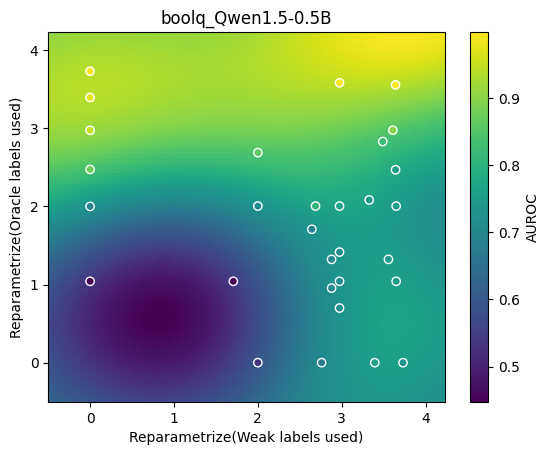

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

ds_name = "boolq_Qwen1.5-0.5B"
plot_df = df[df["ds_name"] == ds_name]

def reparametrize(x):
    return np.log10(x + 1)
    # return x
X = reparametrize(np.stack([plot_df["num_weak"].values, plot_df["num_oracle"].values], axis=1))  # type: ignore
y = plot_df["auroc"]

# Define the Gaussian Process model
kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)

# Fit the model
gp.fit(X, y)

# Create a grid for prediction
x_range = np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 100)
y_range = np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 100)
xx, yy = np.meshgrid(x_range, y_range)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

# Predict on the grid
Z, Z_std = gp.predict(Xgrid, return_std=True)  # type: ignore
Z, Z_std = Z.reshape(xx.shape), Z_std.reshape(xx.shape)

# Plot
fig, ax = plt.subplots()
im = ax.imshow(Z, extent=[x_range.min(), x_range.max(), y_range.min(), y_range.max()],
               origin='lower', aspect='auto', cmap='viridis')
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='w')
plt.colorbar(im, label='AUROC')
ax.set_xlabel('Reparametrize(Weak labels used)')
ax.set_ylabel('Reparametrize(Oracle labels used)')
ax.set_title(f"{ds_name}")
plt.show()

In [7]:
oracle_affordable = 5000  # if you spent your whole budget on oracle, how many oracle labels could you afford?
weak_affordable = 3000
cost_ratio = weak_affordable / oracle_affordable
n_wo = np.stack([np.linspace(0, weak_affordable, 101), np.linspace(oracle_affordable, 0, 101)], axis=1)
auroc, auroc_cov = gp.predict(reparametrize(n_wo), return_std=False, return_cov=True)  # type: ignore

interp_df = pd.DataFrame({
    "num_weak": n_wo[:, 0],
    "num_oracle": n_wo[:, 1],
    "auroc": auroc,
})
interp_df["oracle_spending_frac"] = cost_ratio * interp_df["num_oracle"] / (cost_ratio * interp_df["num_oracle"] + interp_df["num_weak"])

# we want the expected optimal oracle spending fraction
# we compute the expectation over the gaussian process model
# by sampling a bunch of auroc trajectories and computing the argmax
n_boot = 1000
auroc_samples = gp.sample_y(reparametrize(n_wo), n_samples=n_boot).T
argmaxes = np.argmax(auroc_samples, axis=1)
optimal_spending_frac = interp_df["oracle_spending_frac"].values[argmaxes]
interp_df["expected_optimal_spending_frac"] = optimal_spending_frac.mean()
interp_df["optimal_spending_frac_lo"] = np.percentile(optimal_spending_frac, 2.5)
interp_df["optimal_spending_frac_hi"] = np.percentile(optimal_spending_frac, 97.5)

interp_df

,num_weak,num_oracle,auroc,oracle_spending_frac,expected_optimal_spending_frac,optimal_spending_frac_lo,optimal_spending_frac_hi
0,0.0,5000.0,0.938704,1.00,0.83019,0.52975,1.0
1,30.0,4950.0,0.926697,0.99,0.83019,0.52975,1.0
2,60.0,4900.0,0.928929,0.98,0.83019,0.52975,1.0
3,90.0,4850.0,0.931398,0.97,0.83019,0.52975,1.0
4,120.0,4800.0,0.933522,0.96,0.83019,0.52975,1.0
...,...,...,...,...,...,...,...
96,2880.0,200.0,0.777561,0.04,0.83019,0.52975,1.0
97,2910.0,150.0,0.768455,0.03,0.83019,0.52975,1.0
98,2940.0,100.0,0.759102,0.02,0.83019,0.52975,1.0
99,2970.0,50.0,0.751587,0.01,0.83019,0.52975,1.0


Text(0.5, 1.0, 'boolq_Qwen1.5-0.5B\n3000 weak affordable, 5000 oracle affordable')

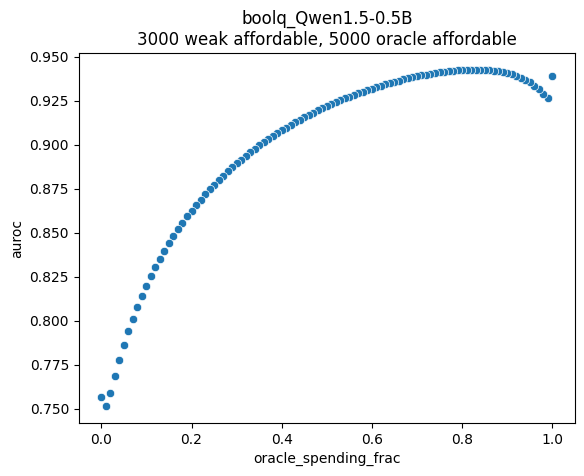

In [8]:
import seaborn as sns

sns.scatterplot(x="oracle_spending_frac", y="auroc", data=interp_df)
plt.title(f"{ds_name}\n{weak_affordable} weak affordable, {oracle_affordable} oracle affordable")

In [9]:
from scipy.stats import linregress
optimal_oracle_spending_frac = interp_df["oracle_spending_frac"].iloc[interp_df["auroc"].argmax()]
r = linregress(interp_df["oracle_spending_frac"], interp_df["auroc"]).rvalue
r

0.8756800582764533

In [10]:
results_df

,auroc,num_oracle,num_weak,seed,ds_name
ds_name,,,,,
boolq_Qwen1.5-0.5B,0.734536,25,941,4,boolq_Qwen1.5-0.5B
boolq_Qwen1.5-0.5B,0.714211,99,0,4,boolq_Qwen1.5-0.5B
boolq_Qwen1.5-0.5B,0.726902,8,756,4,boolq_Qwen1.5-0.5B
boolq_Qwen1.5-0.5B,0.815629,676,3084,4,boolq_Qwen1.5-0.5B
boolq_Qwen1.5-0.5B,0.945134,5381,0,4,boolq_Qwen1.5-0.5B
...,...,...,...,...,...
sciq_support_contains_gt_amplified,0.963379,10,49,4,sciq_support_contains_gt_amplified
sciq_support_contains_gt_amplified,0.989709,295,0,4,sciq_support_contains_gt_amplified
sciq_support_contains_gt_amplified,0.995695,2576,0,4,sciq_support_contains_gt_amplified


In [13]:
from tqdm import tqdm
# optimal spending frac vs: weak quality, weak_affordable, oracle_affordable, distractor salience, desired salience
# TODO: include error bars based on GP std

results = []
for row in tqdm(df.iloc, total=len(df)):
    for weak_affordable in 10 ** np.linspace(0, 4, 5):
        for oracle_affordable in 10 ** np.linspace(0, 4, 5):
            curr_df = results_df[(results_df["ds_name"] == row["ds_name"])]
            n_wo = np.stack([np.linspace(0, weak_affordable, 101), np.linspace(oracle_affordable, 0, 101)], axis=1)
            X = reparametrize(np.stack([curr_df["num_weak"].values, curr_df["num_oracle"].values], axis=1))  # type: ignore
            y = curr_df["auroc"]
            cost_ratio = weak_affordable / oracle_affordable

            # Define the Gaussian Process model
            kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)
            gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)

            # Fit the model
            gp.fit(X, y)
            auroc, auroc_std = gp.predict(reparametrize(n_wo), return_std=True)
            oracle_spending_frac = cost_ratio * n_wo[:, 1] / (cost_ratio * n_wo[:, 1] + n_wo[:, 0])
            
            n_boot = 1000
            auroc_samples = gp.sample_y(reparametrize(n_wo), n_samples=n_boot).T
            argmaxes = np.argmax(auroc_samples, axis=1)
            optimal_oracle_spending_frac = oracle_spending_frac[argmaxes]
            optimal_oracle_spending_frac_mean = optimal_oracle_spending_frac.mean()
            optimal_oracle_spending_frac_lo = np.percentile(optimal_oracle_spending_frac, 2.5)
            optimal_oracle_spending_frac_hi = np.percentile(optimal_oracle_spending_frac, 97.5)
            r = linregress(oracle_spending_frac, auroc).rvalue
            results.append({
                "ds_name": row["ds_name"],
                "seed": row["seed"],
                "weak_label_auroc": row["weak_label_auroc"],
                "weak_label_acc": row["weak_label_acc"],
                "auroc": auroc.max(),
                "auroc_std": auroc_std[auroc.argmax()],
                "aurocs": auroc,
                "auroc_stds": auroc_std,
                "oracle_spending_frac": oracle_spending_frac,
                "salience_weak": row["salience_weak"],
                "salience_oracle": row["salience_oracle"],
                "weak_affordable": weak_affordable,
                "oracle_affordable": oracle_affordable,
                "expected_optimal_oracle_spending_frac": optimal_oracle_spending_frac_mean,
                "optimal_oracle_spending_frac_lo": optimal_oracle_spending_frac_lo,
                "optimal_oracle_spending_frac_hi": optimal_oracle_spending_frac_hi,
                "r": r
            })

all_df = pd.DataFrame(results)

 89%|████████▉ | 240/270 [24:20<03:02,  6.10s/it]/home/alex/.conda/envs/w2s2/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/alex/.conda/envs/w2s2/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/alex/.conda/envs/w2s2/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [14]:
all_df.to_pickle("results/optimal_spending_frac.pkl")

In [15]:
all_df = pd.read_pickle("results/optimal_spending_frac.pkl")

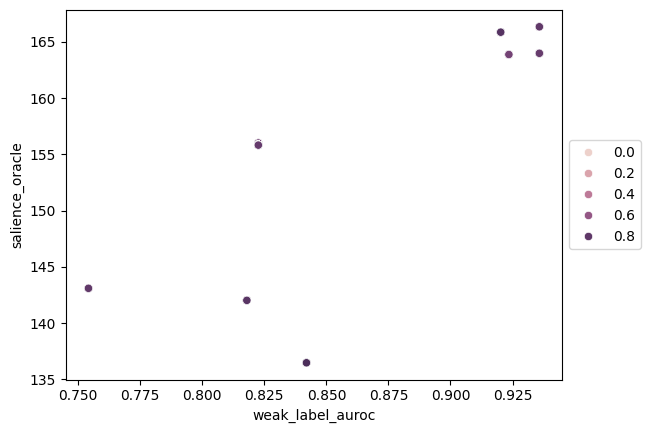

In [16]:
sns.scatterplot(x="weak_label_auroc", y="salience_oracle", hue="expected_optimal_oracle_spending_frac", data=all_df)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

[]

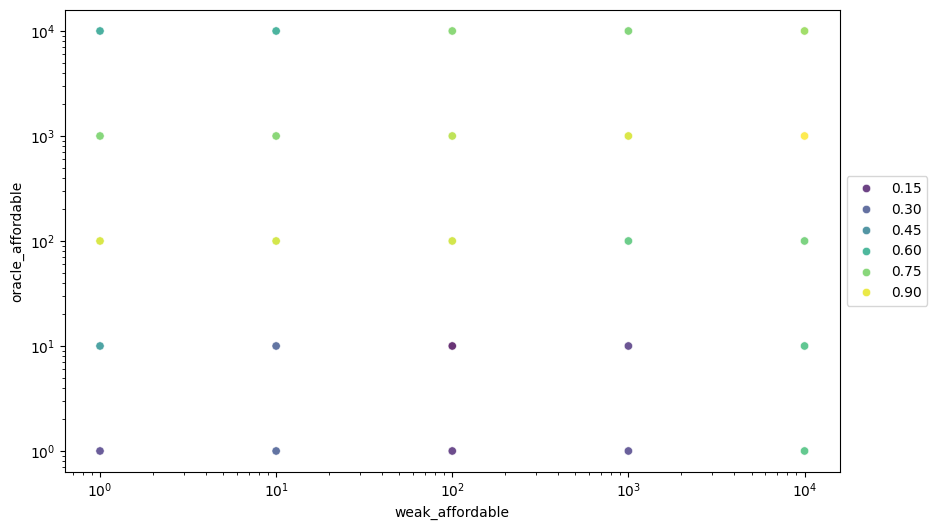

In [24]:
gb_df = all_df.groupby(["weak_affordable", "oracle_affordable"]).mean(numeric_only=True).reset_index()
plt.figure(figsize=(10, 6))
sns.scatterplot(x="weak_affordable", y="oracle_affordable", hue="expected_optimal_oracle_spending_frac", data=gb_df, alpha=0.8, palette="viridis")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.loglog()

In [18]:
sns.scatterplot(x="weak_label_auroc", y="salience_oracle", hue="optimal_oracle_spending_frac", data=all_df)

ValueError: Could not interpret value `optimal_oracle_spending_frac` for `hue`. An entry with this name does not appear in `data`.

In [19]:
all_df[all_df["weak_label_auroc"] > 0.9].sort_values("optimal_oracle_spending_frac", ascending=False)

KeyError: 'optimal_oracle_spending_frac'

In [20]:
# do multiple linear regression of optimal spending frac on weak quality, log_weak_affordable, log_oracle_affordable, distractor salience, desired salience
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

all_df["log_weak_affordable"] = np.log10(all_df["weak_affordable"])
all_df["log_oracle_affordable"] = np.log10(all_df["oracle_affordable"])
X = all_df[["weak_label_auroc", "log_weak_affordable", "log_oracle_affordable", "salience_weak", "salience_oracle"]].values
y = all_df["optimal_oracle_spending_frac"].values
lr = LinearRegression()
lr.fit(X, y)
lr.coef_

KeyError: 'optimal_oracle_spending_frac'

(array([ 750.,    0.,    0., 2250.,  750.,    0.,    0.,    0.,    0.,
        3000.]),
 array([0.75414782, 0.7723139 , 0.79047999, 0.80864608, 0.82681216,
        0.84497825, 0.86314434, 0.88131042, 0.89947651, 0.9176426 ,
        0.93580868]),
 <BarContainer object of 10 artists>)

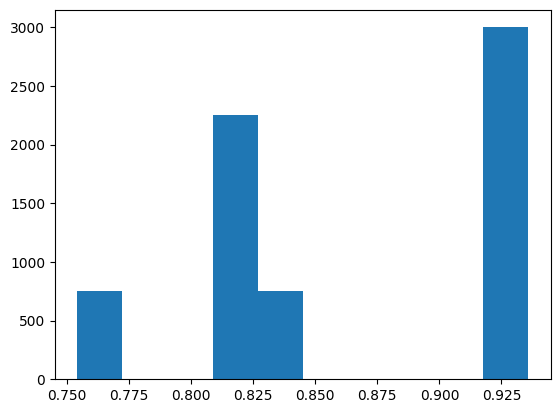

In [21]:
plt.hist(X[:, 0])

ValueError: x and y must be the same size

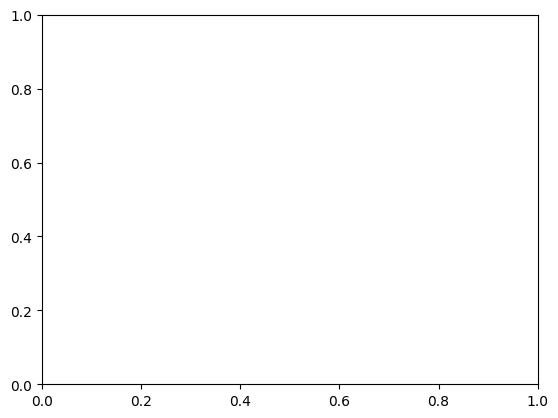

In [22]:
plt.scatter(X[:, 0], y)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  8., 11.,  7.]),
 array([0.57016593, 0.57873925, 0.58731256, 0.59588588, 0.6044592 ,
        0.61303251, 0.62160583, 0.63017915, 0.63875246, 0.64732578,
        0.6558991 , 0.66447241, 0.67304573, 0.68161904, 0.69019236,
        0.69876568, 0.70733899, 0.71591231, 0.72448563, 0.73305894,
        0.74163226, 0.75020558, 0.75877889, 0.76735221, 0.77592552,
        0.78449884, 0.79307216, 0.80164547, 0.81021879, 0.81879211,
        0.82736542, 0.83593874, 0.84451205, 0.85308537, 0.86165869,
        0.870232  , 0.87880532, 0.88737864, 0.89595195, 0.90452527,
        0.91309859, 0.9216719 , 0.93024522, 0.93881853, 0.94739185,
        0.95596517, 0.96453848, 0.9731118 , 0.98168512, 0.99025843,
        0.99883175]),
 <BarContainer

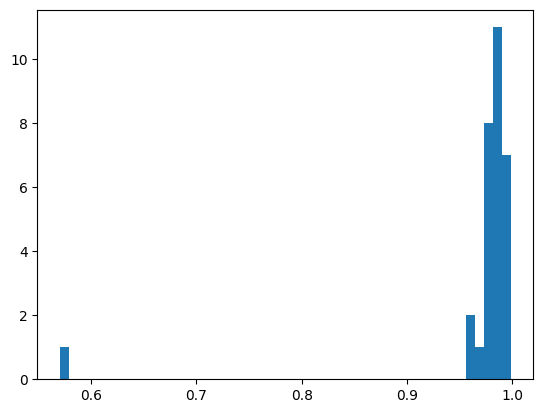

In [23]:
plt.hist(y, bins=50)

0.0
0.5000000000000001
1.0


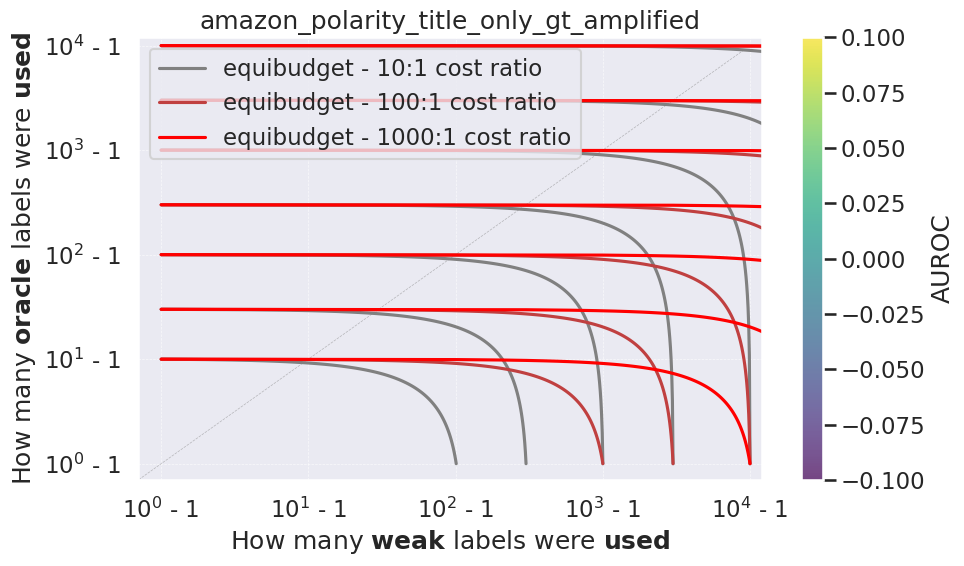

In [248]:
import numpy as np
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# ds_name = "boolq_Qwen1.5-0.5B"
ds_name = "amazon_polarity_title_only_gt_amplified"
plot_df = df[df["ds_name"] == ds_name]
min_auroc = round(plot_df["auroc"].quantile(0.25), 2)
max_auroc = round(plot_df["auroc"].max(), 2)
# Create a scatter plot with total_spent on x-axis and oracle_cost on y-axis
jitter = 0.0
norm = Normalize(vmin=min_auroc, vmax=max_auroc)
colors = plt.cm.viridis(np.linspace(0, 1, 256))
n_bins = 256
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)
cmap.set_under('black')
scatter = ax.scatter((plot_df['num_weak'] + 1) * np.random.normal(1, jitter, len(plot_df)), (plot_df['num_oracle'] + 1) * np.random.normal(1, jitter, len(plot_df)), c=plot_df['auroc'], cmap=cmap, s=100, norm=norm, alpha=0.7)
plt.plot([0, 9000], [0, 9000], color="gray", linestyle="--", alpha=0.5, linewidth=0.5)

cmap = LinearSegmentedColormap.from_list('gray_to_red', ["gray", "red"], N=256)
crs = [10, 100, 1000]
for cost_ratio in crs:
    # color should be near gray if log(cr) is small, and near red if log(cr) is large
    color = (np.log(cost_ratio) - min(map(np.log, crs))) / (max(map(np.log, crs)) - min(map(np.log, crs))) 
    print(color)
    color = cmap(color)
    for oint in [10, 30, 100, 300, 1000, 3000, 10_000]:
        plt.plot(np.linspace(oint * cost_ratio + 1, 1, 101), np.linspace(1, oint, 101), color=color, linestyle="-", label=f"equibudget - {cost_ratio}:1 cost ratio" if oint == 10 else None)
plt.legend()

# Set labels and title
ax.set_xlabel("How many $\\bf{weak}$ labels were $\\bf{used}$")
ax.set_ylabel("How many $\\bf{oracle}$ labels were $\\bf{used}$")
ax.set_title(f"{ds_name}")

plt.loglog()
# replace tick labels with 10^i - 1
ticks = [1, 10, 100, 1000, 10000]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels([f"$10^{int(np.log10(tick))}$ - 1" for tick in ticks])
ax.set_yticklabels([f"$10^{int(np.log10(tick))}$ - 1" for tick in ticks])
ax.set_xlim(0.7, 12_000)
ax.set_ylim(0.7, 12_000)

cbar = plt.colorbar(scatter)
cbar.set_label('AUROC')

ax.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)

plt.tight_layout()
plt.show()


NameError: name 'f_df' is not defined

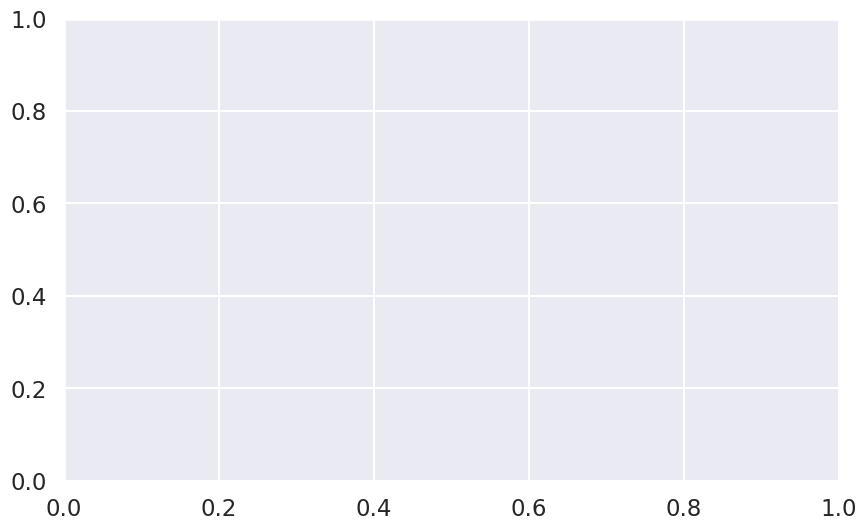

In [249]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

ds_name = "amazon_polarity_title_only"
plot_df = f_df[f_df["ds_name"] == ds_name]
min_auroc = round(plot_df["auroc"].quantile(0.5), 2)
max_auroc = round(plot_df["auroc"].max(), 2)
# plot_df = plot_df[plot_df["auroc"] > min_auroc]
# Create a scatter plot with total_spent on x-axis and oracle_cost on y-axis
jitter = 0.1
scatter = ax.scatter((plot_df['max_weak'] + 1) * np.random.normal(1, jitter, len(plot_df)), (plot_df['max_oracle'] + 1) * np.random.normal(1, jitter, len(plot_df)), c=plot_df['frac_spent_on_oracle'], cmap='viridis', s=((plot_df["auroc"] - min_auroc) * 250 / (max_auroc - min_auroc)).apply(lambda x: max(10, x)), marker='o', alpha=0.7)
plt.plot([0, 9000], [0, 9000], color="black", linestyle="--")

# Set labels and title
ax.set_xlabel("How many $\\bf{weak}$ labels can be $\\bf{afforded}$")
ax.set_ylabel("How many $\\bf{oracle}$ labels can be $\\bf{afforded}$")
ax.set_title(f"{ds_name}")

plt.loglog()
# replace tick labels with 10^i - 1
ticks = [1, 10, 100, 1000, 10000]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels([f"$10^{int(np.log10(tick))}$ - 1" for tick in ticks])
ax.set_yticklabels([f"$10^{int(np.log10(tick))}$ - 1" for tick in ticks])

cbar = plt.colorbar(scatter)
cbar.set_label(f'Fraction of budget spent on oracle\nsize $\\approx$ (AUROC - {min_auroc}) / {max_auroc - min_auroc:.2f}')

ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [250]:
df[df["ds_name"] == "amazon_polarity_title_only"].sort_values("auroc", ascending=False)

,auroc,num_oracle,num_weak,seed,ds_name,name_oracle,name_weak,loss_auc_oracle,loss_auc_weak,salience_oracle,...,steps_oracle,steps_weak,losses_oracle,losses_weak,aurocs_oracle,aurocs_weak,smallest_good_num_points_oracle,smallest_good_num_points_weak,weak_label_acc,weak_label_auroc
ds_name,,,,,,,,,,,,,,,,,,,,,


In [ ]:
# possible observations:
#  - num_oracle is the main predictor of performance
#  - using <=100 oracle examples with a bunch of weak examples only partially resolve the gap (for our learning method) ~=> don't use weak labels unless they're wayyy cheaper
#  - for ethics deontology (a harder, less gt-salient, task), the weak labels don't get you much